In [1]:
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import segyio
from shutil import copyfile
from numpy import genfromtxt

import scipy.stats as stats
import math

#added by orrafaellis:
from sklearn import model_selection
from keras import layers
import keras
import tensorflow as tf
from IPython.display import clear_output

from skimage import feature
from skimage.filters import gaussian

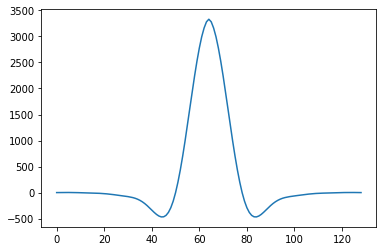

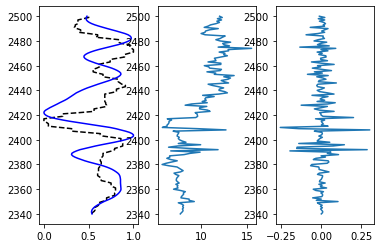

In [2]:
# Loading Impedance and seismic along well and checking if seismic using convolution matches the real seismic 

# Load seismic trace
seismic_data = genfromtxt('../data/volve/seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:,0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices,1]
Ip_trace = seismic_data[unique_indices,2]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]


# Load statistical source wavelet
source_statistical = genfromtxt('../data/volve/statistical_source_wavelet.txt', delimiter='	')
dt_source = 1e-3
plt.plot(source_statistical[:,1])
plt.show()


# Convolution of source with reflectivity series 
r0 = 0.5*np.diff(np.log(Ip_trace_cropped))
r0 = np.insert(r0,0, 0)
ss = np.convolve(r0, source_statistical[:,1], mode='same')
ss_normalized = (ss - np.min(ss))/(np.max(ss) - np.min(ss))

fig, axs = plt.subplots(1,3)
axs[0].plot(seismic_trace_cropped, time_cropped, '--k' )
axs[0].plot(1-ss_normalized, time_cropped, '-b' )
axs[1].plot(Ip_trace_cropped, time_cropped)
axs[2].plot(r0, time_cropped)

plt.show()


# Note to match 1-ss_normalized from impedance inversion

In [3]:
# Load stochastically generated impedance 
Ip = np.loadtxt('../data/volve/Ip_exported.txt')
Ip_reshape = np.reshape(Ip, ((151,151,160)), order='F')

In [4]:
# Trace by trace normalization and convolution 
ss_new = np.zeros(Ip_reshape.shape)
Ip_normalized = np.zeros(Ip_reshape.shape)
for i in range(Ip_reshape.shape[0]):
#     print('Iteration no: '+ str(i) + ' / '+ str(Ip_reshape.shape[0]))
    for j in range(Ip_reshape.shape[1]):
        Ip_trace = Ip_reshape[i,j,:]
        Ip_normalized[i,j,:] = Ip_trace#(Ip_trace - np.min(Ip_trace))/(np.max(Ip_trace) - np.min(Ip_trace))
        r0_trace = 0.5*np.diff(np.log(Ip_trace))
        r0_trace = np.insert(r0_trace,0, 0)
        ss_trace = np.convolve(r0_trace, source_statistical[:,1], mode='same')
        ss_new[i,j,:] = ss_trace#(ss_trace - np.min(ss_trace))/(np.max(ss_trace) - np.min(ss_trace))
            

## Normalização de todos os dados juntos 

In [5]:
seismic_norm = ss_new.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
ss_new = seismic_norm.reshape(ss_new.shape)


In [6]:
pimpedance_norm = Ip_normalized.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
Ip_normalized = pimpedance_norm.reshape(Ip_normalized.shape)
#seismic_norm = seismic

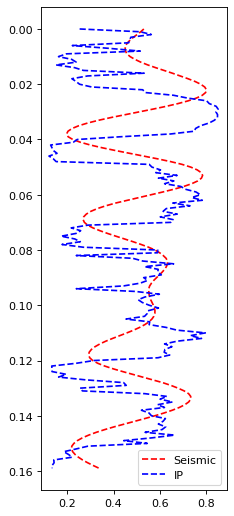

In [7]:
# Plot of results of convolution
time_new = np.arange(0,ss_new.shape[2]*1e-3, 1e-3)
nx = 100
ny = 100
# Ip_trace_normalized = (Ip_reshape[nx, ny, :] - np.min(Ip_reshape[nx, ny, :] ))/(np.max(Ip_reshape[nx, ny, :] ) - np.min(Ip_reshape[nx, ny, :] ))

plt.figure(num=None, figsize=(3, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ss_new[nx,ny,:], time_new, '--r',label='Seismic')
plt.plot(Ip_normalized[nx,ny,:], time_new, '--b',label='IP')
plt.legend()
plt.gca().invert_yaxis()

In [8]:
# Creating training, validation and test data 

# Validation dataset created near the area of the well
indx_i_well_start = 20
indx_i_well_end = 45
indx_j_well_start = 32
indx_j_well_end = 54

valX = ss_new[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valX = valX.reshape(-1, valX.shape[-1])
valX = np.expand_dims(valX,axis=(2,3))

valIp = Ip_normalized[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valIp = valIp.reshape(-1, valIp.shape[-1])
valIp = np.expand_dims(valIp,axis=(2,3))

In [9]:
# Flatten rest of indices 
ss_data_rest = ss_new[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):ss_new.shape[0]], :, :]
ss_data_rest = ss_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):ss_new.shape[1]],:]
ss_data_rest = ss_data_rest.reshape(-1, ss_data_rest.shape[-1])
ss_data_rest = np.expand_dims(ss_data_rest,axis=(2,3))

Ip_data_rest = Ip_normalized[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):Ip_normalized.shape[0]], :, :]
Ip_data_rest = Ip_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):Ip_normalized.shape[1]],:]
Ip_data_rest = Ip_data_rest.reshape(-1, Ip_data_rest.shape[-1])
Ip_data_rest = np.expand_dims(Ip_data_rest,axis=(2,3))

In [10]:
# Selecting randomly training dataset
howMany = 750 # Seismic data considered out of all data points 
np.random.seed(9) # For replication of results
indxRand = [randint(0,ss_data_rest.shape[0]-1) for p in range(0,howMany)]

X_train = (ss_data_rest[indxRand,:,:,:])
Y_train = (Ip_data_rest[indxRand,:,:,:])

In [11]:
all_valid_loc = np.arange(valIp.shape[0])

valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(all_valid_loc,
                                                                      test_size=0.5,
                                                                      train_size=0.5,
                                                                      random_state=9, 
                                                                      shuffle=True)

In [12]:
X_valid = valX[valid_wells_loc,:,:,:]
Y_valid = valIp[valid_wells_loc,:,:,:]

UNLABED_SEISMIC = valX[unlabed_wells_loc,:,:,:] 

In [13]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

#print('     IP (Y_test) shape: ',Y_test.shape)
#print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (750, 160, 1, 1)
seismic (X_train) shape:  (750, 160, 1, 1)
     IP (Y_valid) shape:  (275, 160, 1, 1)
seismic (X_valid) shape:  (275, 160, 1, 1)


## Create the Generator

In [14]:
def get_generator_model():
    noise = layers.Input(shape=(160,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

f_model = get_generator_model()


In [15]:
import keras
import tensorflow as tf
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        plt.plot(self.x[-100:], self.losses[-100:], label="loss")
        plt.plot(self.x[-100:], self.val_losses[-100:], label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [16]:
f_model = get_generator_model()

In [17]:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
#compile model using accuracy to measure model performance

loss_metrics = [
    'mse',
    'mae'
]

metric_funcs = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError()
]

f_model.compile(optimizer=optimizer, loss=loss_metrics, metrics=metric_funcs)

In [18]:
## train the model
f_model_history = f_model.fit(Y_train, X_train,
                              validation_data=(Y_valid, X_valid),
                              epochs=1000,
                              verbose=1,
                              shuffle=True,
                              batch_size=10,
                              #callbacks = [plot_losses]
                             )

Epoch 1/1000
75/75 [==============================] - 4s 22ms/step - loss: 0.4885 - mean_squared_error: 0.4885 - mean_absolute_error: 0.4253 - root_mean_squared_error: 0.6382 - val_loss: 0.1162 - val_mean_squared_error: 0.1162 - val_mean_absolute_error: 0.3100 - val_root_mean_squared_error: 0.3409
Epoch 2/1000
75/75 [==============================] - 1s 7ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1054 - root_mean_squared_error: 0.1338 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1682 - val_root_mean_squared_error: 0.1964
Epoch 3/1000
75/75 [==============================] - 1s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0780 - root_mean_squared_error: 0.0993 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1005 - val_root_mean_squared_error: 0.1229
Epoch 4/1000
75/75 [==============================] - 1s 8ms/step - loss: 0.0072 - mean_squared_error: 0.

In [19]:
predict = f_model(valIp)[:,:,0,0]

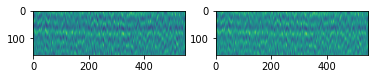

In [20]:
predict = np.transpose(predict.numpy())
fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict)
axes1[1].imshow(np.transpose(valX[:,:,0,0]))

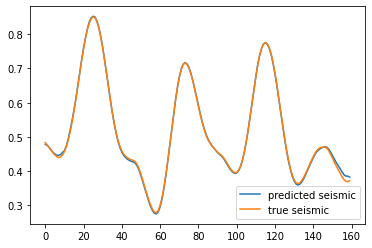

In [21]:
test_trace = np.random.randint(predict.shape[1])
plt.plot(predict[:,test_trace],label='predicted seismic')
plt.plot(valX[test_trace,:,0,0],label='true seismic')
plt.legend()

## Inversion WGAN-GP

In [22]:
BATCH_SIZE = 75
N_EPOCHS = 2000
noise_dim = 160
IMG_SHAPE = (160,1,1)

In [23]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [24]:
def get_discriminator_model():       
    input_disc = layers.Input(shape=IMG_SHAPE)        
    ENC = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same',strides=2)(input_disc)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENC)
        
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENC)
    ENCB1 = layers.ReLU()(ENCB1)
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB1)
    ENCB1 = layers.Add()([ENCB1, ENC])
    ENCB1 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB1)
    ENCB1 = layers.ReLU()(ENCB1)
        
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENCB1)
    ENCB2 = layers.ReLU()(ENCB2)
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB2)
    ENCB2 = layers.Add()([ENCB2, ENCB1])
    ENCB2 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB2)
    ENCB2 = layers.ReLU()(ENCB1)
        
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENCB2)
    ENCB3 = layers.ReLU()(ENCB3)
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB3)
    ENCB3 = layers.Add()([ENCB2, ENCB3])
    ENCB3 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB3)
    ENCB3 = layers.ReLU()(ENCB3)
        
    r1 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=1)(ENCB3)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=3)(ENCB3)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=5)(ENCB3)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=7)(ENCB3)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv2D(filters=64,kernel_size=(3,1),padding='same',strides=2)(assp)
        
        
    fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp)
    lkr_out = layers.LeakyReLU()(fc_out)
    fc2_outFlatten = layers.Flatten()(lkr_out)
    fc2_out = layers.Dense(1,kernel_initializer=tf.keras.initializers.HeNormal())(fc2_outFlatten)
        
    DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
    return DISCmodel

### Create the WGAN-GP models

In [25]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        alpha = tf.random.normal([batch_size, 1, 1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
       
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                
                # gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight 
            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Unlabed seismic mini-batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
                        
            #Seismic loss:
            fake_seis_unlabed = f_model(self.generator(unlabed_batch,training=True))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBacks

In [26]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model

In [27]:
#Initialize internal models: 
g_model = get_generator_model()
d_model = get_discriminator_model()

#optimizers:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss


wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=160,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [28]:
# Initialize model training:
wgan_history = wgan.fit(X_train,
                        Y_train,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        verbose = 1,
                        #callbacks=[checkp_callback]
                       )

Epoch 1/2000
10/10 [==============================] - 19s 142ms/step - d_loss: -4.8256 - g_loss: 578.7054 - imp_loss: 547.4737 - seis_loss: 25.8701
Epoch 2/2000
10/10 [==============================] - 1s 140ms/step - d_loss: -1.0645 - g_loss: 122.4686 - imp_loss: 104.4493 - seis_loss: 13.1598
Epoch 3/2000
10/10 [==============================] - 1s 136ms/step - d_loss: -0.5080 - g_loss: 83.3089 - imp_loss: 69.3175 - seis_loss: 8.68260s - d_loss: -0.4408 - g_loss: 86.1377 - imp_loss: 71.8610 - seis_loss
Epoch 4/2000
10/10 [==============================] - 1s 136ms/step - d_loss: -0.4738 - g_loss: 66.8162 - imp_loss: 55.2504 - seis_loss: 6.1714
Epoch 5/2000
10/10 [==============================] - 1s 129ms/step - d_loss: -0.4391 - g_loss: 57.3609 - imp_loss: 47.8006 - seis_loss: 4.9846
Epoch 6/2000
10/10 [==============================] - 1s 131ms/step - d_loss: -0.5047 - g_loss: 51.9532 - imp_loss: 43.2392 - seis_loss: 4.1454
Epoch 7/2000
10/10 [==============================] - 1s 13

In [29]:
X_predict = wgan.generator(valX)[:,:,0,0]
X_predict = np.transpose(X_predict)


y_predicted = wgan.generator(valX)[:,:,0].numpy()

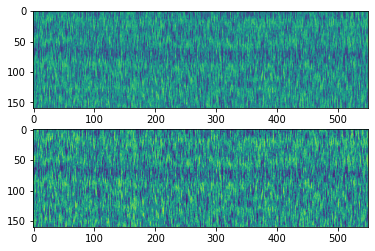

In [30]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1)
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(valIp[:,:,0,0]))

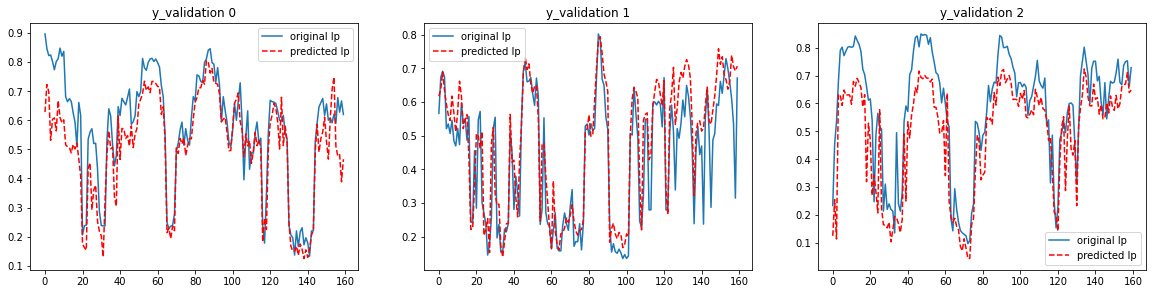

In [63]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict[:,trace_id])
# plt.plot(valIp[trace_id,:,0,0])
# plt.legend(('predicted','target'))
# plt.title('Trace No.: '+str(trace_id))

#y_predicted = lstm_net.predict(x_test, verbose=1)

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(valIp[i-1, :, 0])
    plt.plot(X_predict[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])

#     ax = plt.subplot(2, n, i + n, sharey=ax)
#     ax.set_title("y_predicted {0}".format(i-1))
#     plt.plot(y_predicted[i-1, :, 0])
plt.show()

y_test = valIp[:,:,0]

SSIM:  0.90378827
SSIM Multiscale:  0.9661241


Text(0.5, 1.0, 'Target')

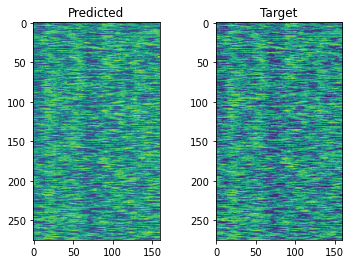

In [64]:
predict_image = y_predicted.flatten()
#predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(y_predicted.shape)
predict_image = (predict_image).astype('float32')

target_image = y_test.flatten()
#target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(y_test.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict_image[275:,:,0])
axes1[0].set_title("Predicted")
axes1[1].imshow(target_image[275:,:,0])
axes1[1].set_title("Target")

In [33]:
mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image.flatten(), predict_image.flatten())

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

MSE:  0.0073442375
MAE:  0.06430233
RMSE:  0.08569853


In [34]:
def soft_F_measure(target_data,
                   predicted_data,
                   canny_sigma=3,
                   gaussian_sigma=1,
                   beta_F1=1,
                   plot_data=True):
    e = feature.canny(target_data, sigma=canny_sigma)
    e_ = feature.canny(predicted_data, sigma=canny_sigma)

    e_ = gaussian(e_,sigma=gaussian_sigma,multichannel=None, preserve_range=True)
    #e_ = e_/np.max(e_.flatten())-np.min(e_.flatten())

    TP = np.minimum(e,e_)
    TN = np.minimum(1-e,1-e_)
    FP = np.maximum(e_ - e , np.zeros(e.shape))
    FN = np.maximum(e - e_ , np.zeros(e.shape))
    sTP = np.sum(TP.flatten())
    sTN = np.sum(TN.flatten())
    sFP = np.sum(FP.flatten())
    sFN = np.sum(FN.flatten())
    
    soft_precision = sTP/(sTP+sFP)
    soft_recall = sTP/(sTP+sFN)
    
    soft_FM = (1+beta_F1**2)*(soft_precision*soft_recall)/(soft_precision*(beta_F1**2)+soft_recall)
    if plot_data:
    
        fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))
        ax[0,0].imshow(target_data)
        ax[0,0].set_title('ground truth')

        ax[1,0].imshow(e, cmap='gray')
        ax[1,0].set_title('ground truth, canny, sigma:{}'.format(canny_sigma))

        ax[0,1].imshow(predicted_data)
        ax[0,1].set_title('predicted')

        ax[1,1].imshow(e_, cmap='gray')
        ax[1,1].set_title('predicted, canny, sigma:{}'.format(canny_sigma))
        
        ax[0,2].imshow(TP)
        ax[0,2].set_title('True Positive')

        ax[1,2].imshow(TN)
        ax[1,2].set_title('True Negative')

        ax[0,3].imshow(FP)
        ax[0,3].set_title('False Positive'.format(canny_sigma))

        ax[1,3].imshow(FN)
        ax[1,3].set_title('False Negative'.format(canny_sigma))

        fig.tight_layout()
        plt.show()
        
    return soft_FM

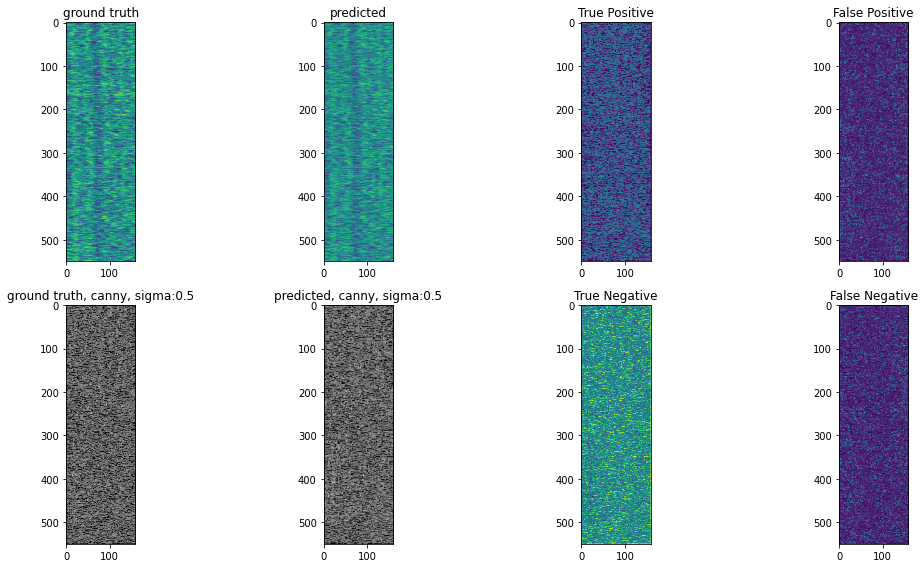

0.6355767330844808


In [35]:
Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1,
                    plot_data=True)

print(Fb)

## Train baseline: CNN = generator

In [36]:
cnn_inversion = get_generator_model()

optimizer_cnn = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion.compile(optimizer=optimizer_cnn, loss=loss_metrics, metrics=metric_funcs)

In [37]:
cnn_history = cnn_inversion.fit(X_train,
                                Y_train,
                                validation_data=(X_valid,Y_valid),
                                epochs=N_EPOCHS,
                                verbose=1,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                # callbacks = [plot_losses,checkpoint]
                               )

Epoch 1/2000
10/10 [==============================] - 1s 39ms/step - loss: 1.4355 - mean_squared_error: 0.6711 - mean_absolute_error: 0.4381 - root_mean_squared_error: 0.8159 - val_loss: 0.2792 - val_mean_squared_error: 0.2792 - val_mean_absolute_error: 0.4823 - val_root_mean_squared_error: 0.5284
Epoch 2/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - mean_absolute_error: 0.3074 - root_mean_squared_error: 0.3718 - val_loss: 0.2353 - val_mean_squared_error: 0.2353 - val_mean_absolute_error: 0.4368 - val_root_mean_squared_error: 0.4851
Epoch 3/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0770 - mean_squared_error: 0.0770 - mean_absolute_error: 0.2214 - root_mean_squared_error: 0.2774 - val_loss: 0.2000 - val_mean_squared_error: 0.2000 - val_mean_absolute_error: 0.3930 - val_root_mean_squared_error: 0.4472
Epoch 4/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0568 - mean_squared_error:

In [38]:
X_predictCNN = cnn_inversion(valX)[:,:,0,0]
X_predictCNN = np.transpose(X_predictCNN)

Text(0.5, 1.0, 'CNN inversion')

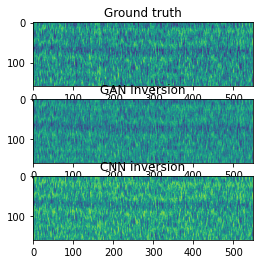

In [39]:
fig1, axes1 = plt.subplots(nrows=3, ncols=1)
axes1[0].imshow(np.transpose(valIp[:,:,0,0]))
axes1[0].set_title("Ground truth")

axes1[1].imshow(X_predict)
axes1[1].set_title("GAN Inversion")

axes1[2].imshow(X_predictCNN)
axes1[2].set_title("CNN inversion")

Text(0.5, 1.0, 'Trace No.: 521')

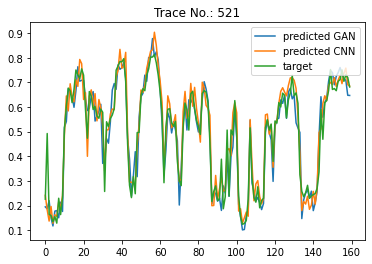

In [40]:
trace_id = np.random.randint(X_predictCNN.shape[1])
plt.plot(X_predict[:,trace_id],label='predicted GAN')
plt.plot(X_predictCNN[:,trace_id],label='predicted CNN')
plt.plot(valIp[trace_id,:,0,0],label='target')
plt.legend()
plt.title('Trace No.: '+str(trace_id))